In [1]:
import numpy as np
import matplotlib.pyplot as plt

import logging
logging.getLogger('matplotlib.font_manager').disabled = True

import ipywidgets as widgets  # interactive display
%config InlineBackend.figure_format = 'retina'
# use NMA plot style
plt.style.use("https://raw.githubusercontent.com/NeuromatchAcademy/course-content/main/nma.mplstyle")
my_layout = widgets.Layout()

<h1 style="background-color:rgb(181 ,50 ,84);color:white;text-align:center">Hodgkin and Huxley model</h1>

In [2]:
# typical neuron parameters#
u_rest = -75.   # reset potential [mV]

gmax_Na = 120.   # Average sodium channel conductance per unit area (mS/cm^2)
gmax_K = 36.    # Average potassium channel conductance per unit area (mS/cm^2)
gmax_L = 0.3    # Average leak channel conductance per unit area (mS/cm^2)
Cm = 1.0        # Membrane capacitance per unit area (uF/cm^2)
ENa = 55.       # Sodium potential (mV)
EK = -77.       # Potassium potential (mV)
El = -65.       # Leak potential (mV)

# Simulation parameters 
T = 40.  # Total duration of simulation [ms]
dt = .01   # Simulation time step [ms]

# Time vector
t = np.arange(0, T+dt, dt)

In [3]:
class HH():
    def __init__(self, u_rest=-68.5, gmax_Na=120, gmax_K=35, gmax_L=0.3, Cm=1.0, ENa=55, EK=-77, EL=-65):
        self.u_rest = u_rest
        self.gmax_Na = gmax_Na
        self.gmax_K = gmax_K
        self.gmax_L = gmax_L
        self.ENa = ENa
        self.EK = EK
        self.EL = EL
        self.Cm = Cm
        self.tau = self.Cm / self.gmax_L

    def alpha_m(self, u):
        return 0.1*(u+40.0)/(1.0 - np.exp(-(u+40.0) / 10.0))

    def beta_m(self, u):
        return 4.0*np.exp(-(u+65.0) / 18.0)

    def alpha_h(self, u):
        return 0.07*np.exp(-(u+65.0) / 20.0)

    def beta_h(self, u):
        return 1.0/(1.0 + np.exp(-(u+35.0) / 10.0))

    def alpha_n(self, u):
        return 0.01*(u+55.0)/(1.0 - np.exp(-(u+55.0) / 10.0))

    def beta_n(self, u):
        return 0.125*np.exp(-(u+65) / 80.0)

    def gNa(self, m, h):
        return self.gmax_Na*m**3*h

    def gK(self, n):
        return self.gmax_K*n**4

    def gL(self):
        return self.gmax_L

    def INa(self, m, h, u):
        return self.gNa(m, h)*(u - self.ENa)

    def IK(self, n, u):
        return self.gK(n)*(u - self.EK)

    def IL(self, u):
        return self.gL()*(u - self.EL)

    def n_dot(self, u, n):
        return self.alpha_n(u)*(1 - n) - self.beta_n(u)*n

    def m_dot(self, u, m):
        return self.alpha_m(u)*(1 - m) - self.beta_m(u)*m

    def h_dot(self, u, h):
        return self.alpha_h(u)*(1 - h) - self.beta_h(u)*h

    def u_dot(self, u, m, h, n, I):
        return (I - self.INa(m, h, u) - self.IK(n, u) - self.IL(u)) / self.Cm

    def simulate(self, t_range, dt, I):
        u = np.zeros_like(t_range)
        m = np.zeros_like(t_range)
        h = np.zeros_like(t_range)
        n = np.zeros_like(t_range)

        u[0] = self.u_rest
        m[0] = self.alpha_m(u[0]) / (self.alpha_m(u[0]) + self.beta_m(u[0]))
        h[0] = self.alpha_h(u[0]) / (self.alpha_h(u[0]) + self.beta_h(u[0]))
        n[0] = self.alpha_n(u[0]) / (self.alpha_n(u[0]) + self.beta_n(u[0]))

        for i in range(len(t_range) - 1):
            u[i+1] = u[i] + dt*self.u_dot(u[i], m[i], h[i], n[i], I[i])
            m[i+1] = m[i] + dt*self.m_dot(u[i], m[i])
            h[i+1] = h[i] + dt*self.h_dot(u[i], h[i])
            n[i+1] = n[i] + dt*self.n_dot(u[i], n[i])

        return u, m, h, n

    def plot_state(self, t, I, X):
        fig, ax = plt.subplots(2, 2, figsize=(14, 5))

        ax[0, 0].plot(t, I, label='Input current')
        ax[0, 0].set_xlabel('Time (ms)')
        ax[0, 0].set_ylabel('Current (uA/cm^2)')
        ax[0, 0].legend()

        ax[0, 1].plot(t, X[0], label='Voltage')
        ax[0, 1].set_xlabel('Time (ms)')
        ax[0, 1].set_ylabel('Voltage (mV)')
        ax[0, 1].legend()

        ax[1, 0].plot(t, self.gNa(X[1], X[2]), label='gNa')
        ax[1, 0].plot(t, self.gK(X[3]), label='gK')
        ax[1, 0].plot(t, self.gL()*np.ones_like(t), label='gL')
        ax[1, 0].set_xlabel('Time (ms)')
        ax[1, 0].set_ylabel('Conductance (mS/cm^2)')
        ax[1, 0].legend()

        ax[1, 1].plot(t, X[1], label='m')
        ax[1, 1].plot(t, X[2], label='h')
        ax[1, 1].plot(t, X[3], label='n')
        ax[1, 1].set_xlabel('Time (ms)')
        ax[1, 1].legend()

        plt.show()

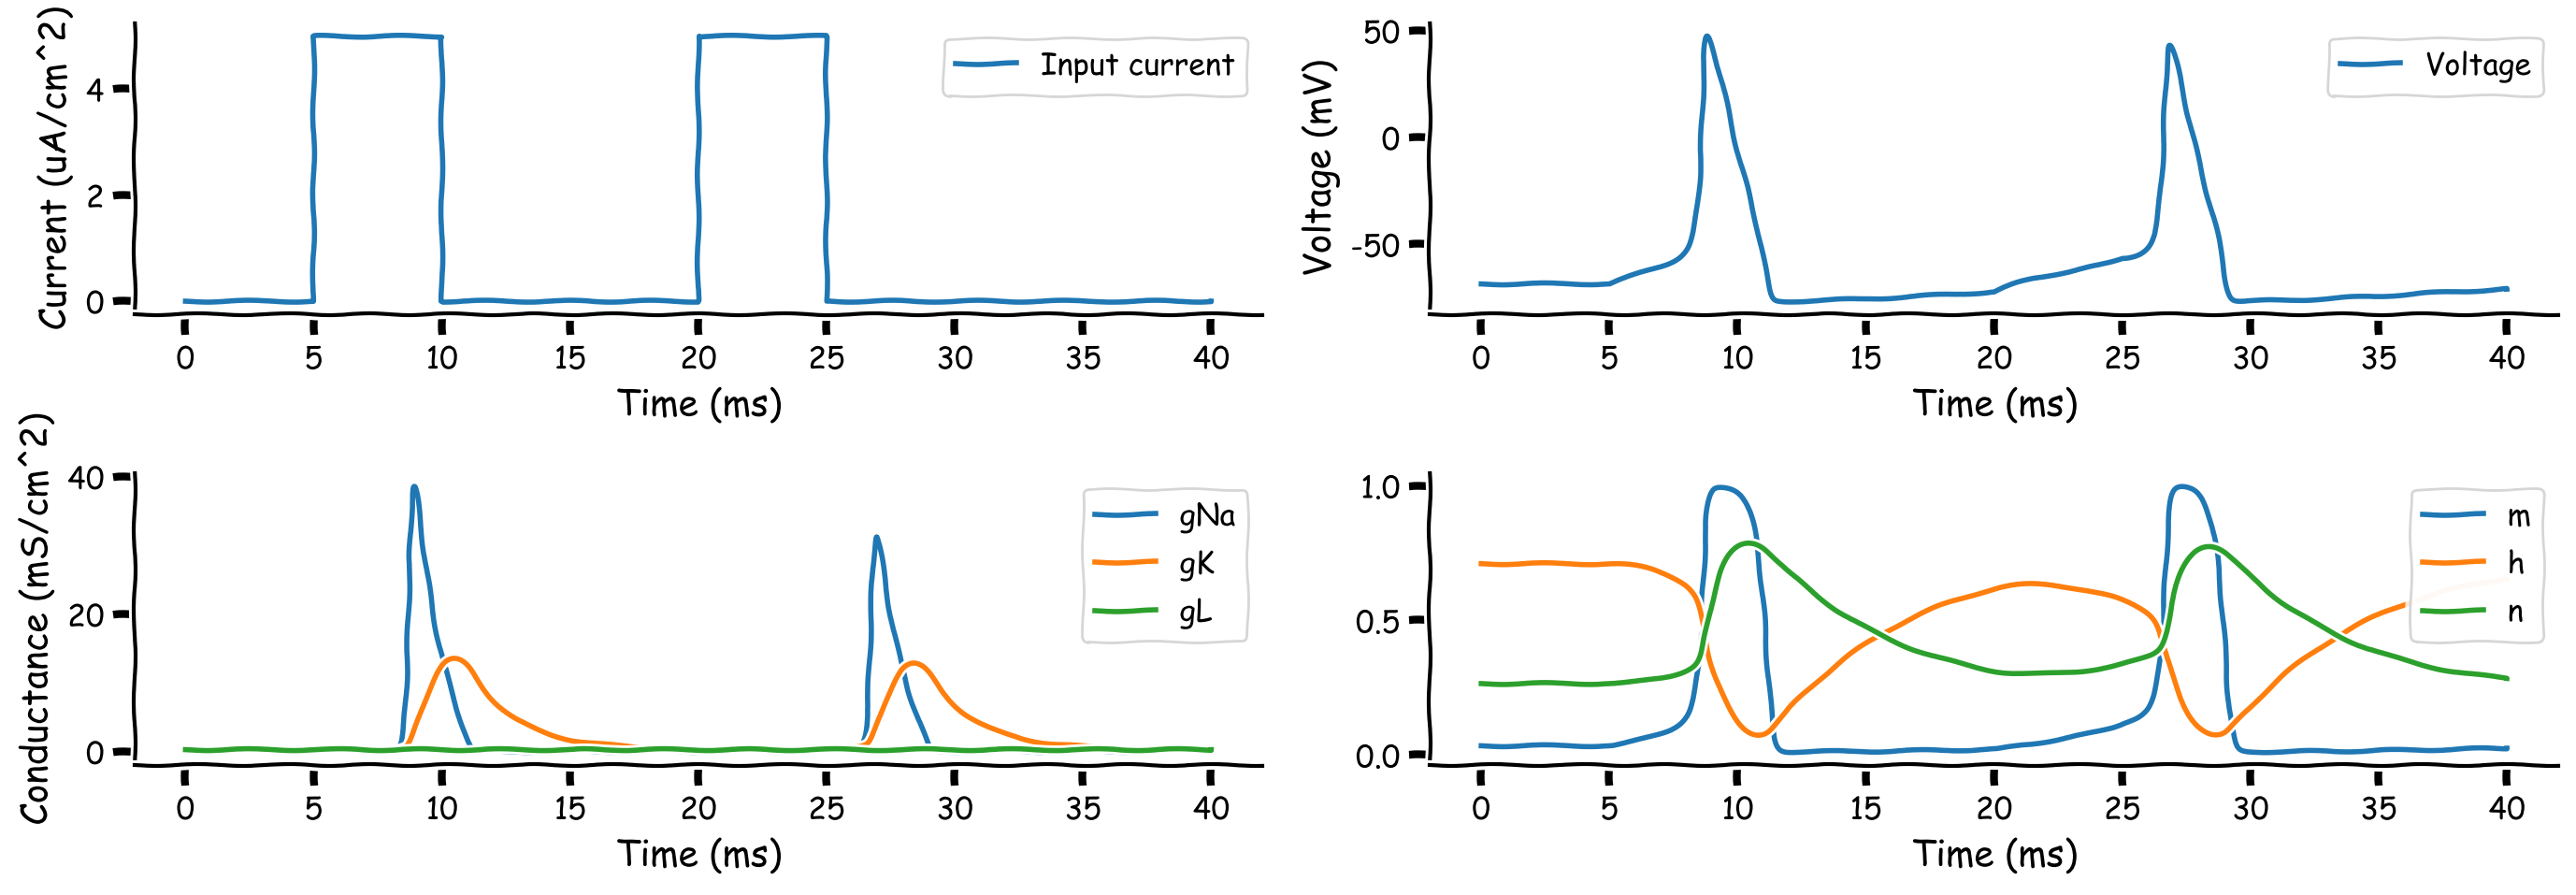

In [8]:
# Example simulation
hh = HH()

I_amp = 5
I = np.zeros_like(t)
I[500:1000] = I_amp
I[2000:2500] = I_amp

# Simulation
X = hh.simulate(t, dt, I)

with plt.xkcd():
    hh.plot_state(t, I, X)


In [16]:
def run_interactive_simulation(input_current):
    hh = HH()
     
    @widgets.interact(
        I_amp = widgets.FloatSlider(10., min=0., max=50., step=.5, layout=my_layout),
    )

    def diff_DC(I_amp):
        # Change parameters
        I = input_current(t, I_amp)

        # Simulation
        X = hh.simulate(t, dt, I)

        # Plot
        with plt.xkcd():
            hh.plot_state(t, I, X)

In [17]:
def input_current(t, I_amp=50):
    I = np.sin(t) * I_amp
    return I
    
run_interactive_simulation(input_current)

interactive(children=(FloatSlider(value=10.0, description='I_amp', max=50.0, step=0.5), Output()), _dom_classe…